# **응급상황 자동 인식 및 응급실 연계 서비스**
# **단계1 : 응급상황 음성 인식 및 요약**

## **0.미션**

단계 1에서는, 응급상황의 음성을 인식해서 텍스트로 변환하고, 변환된 텍스트를 다시 요약 및 핵심키워드 도출 작업을 수행합니다.  
이를 위해 사전학습된 모델을 API로 연결하여 활용합니다.

### (1) 미션1
* 음성인식 : STT(Speech-to-Text)
    * 사용 모델 : OpenAI의 **Whisper-1**
    * 제공받은 음성 파일과 새로 제작하는 5건 이상의 음성파일을 텍스트로 변환하고, 변환작업이 잘 되는지 확인해 봅시다.

### (2) 미션2
* 텍스트 요약 및 핵심 키워드 도출
    * 사용 모델 : OpenAI의 **GPT-3.5-turbo**
    * 내용 요약과 주요 키워드를 도출하도록
    프롬프트 입력과 출력을 구성하고 테스트 해 봅시다.

* [추가]응급실 현황 다운로드(이 데이터는 단계3에서 필요합니다.)



## **1.환경설정**

### (1) 경로 설정

구글 드라이브 연결

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(project6_2)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project6_2/'

### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

* requirements.txt 파일의 [경로 복사]를 한 후,
* 아래 경로에 붙여 넣기

In [ ]:
# 경로 : /content/drive/MyDrive/project6_2/requirements.txt
# 경로가 다른 경우 아래 코드의 경로 부분을 수정하세요.

!pip install -r /content/drive/MyDrive/project6_2/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


#### 2) 라이브러리 로딩

In [ ]:
#필요한 라이브러리 설치 및 불러우기
import os
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
import json

# 더 필요한 라이브러리 추가 -------------




### (3) OpenAI API Key 환경 변수 설정

* 제공받은 open ai api key를 **api_key.txt** 파일에 저장합니다.
    * (제공받은 api_key.txt 파일은 비어 있습니다.)

* 다음 코드를 통해 환경변수로 등록 합니다.

In [ ]:
def load_file(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# API 키 로드 및 환경변수 설정
openai.api_key = load_file(path + 'api_key.txt')
os.environ['OPENAI_API_KEY'] = openai.api_key

* ⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 결과는 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'])

## **2. 미션1 : STT**

### (1) 제공된 데이터 변환
* 세부사항
    * 사용 모델 : whisper-1
    * 제공 받은 오디오 파일을 읽어서 텍스트로 변환시켜 봅시다.
        * 반복문을 통해 파일 하나씩 읽어서 텍스트 변환
        * 변환된 텍스트를 데이터 프레임에 추가

|filename|text|
|----|----|
|audio3.mp3|어쩌구 저쩌구...급해요.|

* 음성파일 변환

In [ ]:
# 음성파일 경로 지정
audio_path = '/content/drive/MyDrive/KT/6차2/audio/'

In [ ]:
# OpenAI 클라이언트 생성
client = OpenAI()

In [ ]:
# 위스퍼 모델 사용 : 제공된 음성파일 중 1개를 텍스트로 변환해보기
filename = 'audio2.mp3'
audio_file = open(audio_path + filename, "rb")
transcript = client.audio.transcriptions.create(
    file=audio_file,
    model="whisper-1",
    language="ko",
    response_format="text",
)

print(transcript, type(transcript))

119죠. 제가 지금 열이 열이 올랐어요. 몇 도냐면은 38도 정도 돼요. 머리가 아프고 좀 띵한 것 같아요. 우한이 좀 들어요. 어떻게 해야 할까요?
 <class 'str'>


* 음성파일 변환 함수 생성

In [ ]:
def audio_to_text(audio_path, filename):
    # OpenAI 클라이언트 생성
    client = OpenAI()

    # 오디오 파일을 읽어서, 위스퍼를 사용한 변환
    file_path = f"{audio_path}/{filename}"

    # 결과 반환
    try:
        with open(file_path, "rb") as audio_file:
            transcript = client.audio.transcriptions.create(
                file=audio_file,
                model="whisper-1",
                language="ko",
                response_format="text",
            )
        return transcript
    except Exception as e:
        return f"Error occurred: {str(e)}"


In [ ]:
# 음성파일 이름을 리스트에 담기
file_names = [f for f in os.listdir(audio_path) if os.path.isfile(os.path.join(audio_path, f))]
print(file_names)

['audio3.mp3', 'audio4.mp3', 'audio1.mp3', 'audio5.mp3', 'audio2.mp3']


In [ ]:
# 반복문을 통해, 파일 하나씩 읽어서 텍스트 변환, 변환된 텍스트를 데이터 프레임에 추가

# 빈 데이터프레임 선언
df = pd.DataFrame(columns=["Filename", "Transcript"])

# 반복문 수행하면서 오디오 변환
data_list = []  # 변환 결과를 저장할 리스트
for filename in file_names:
    print(f"Processing file: {filename}")
    transcript = audio_to_text(audio_path, filename)
    data_list.append({"Filename": filename, "Transcript": transcript})  # 결과를 리스트에 추가

df = pd.DataFrame(data_list)
# 데이터프레임 결과 조회
print(df)

Processing file: audio3.mp3
Processing file: audio4.mp3
Processing file: audio1.mp3
Processing file: audio5.mp3
Processing file: audio2.mp3
     Filename                                         Transcript
0  audio3.mp3  동생이 콩 가지고 놀다가 코에 들어가서 한쪽 코가 막혔어요. 아무리 빼보려 해도 안...
1  audio4.mp3  아까 가다가 머리를 박았는데, 처음에는 괜찮다가, 지금 3시간 정도 지났는데, 머리...
2  audio1.mp3  지금 아빠가 넘어졌어요. 머리에서 피가 나는데 숨은 쉬고 있어요. 지금 막 일어났어...
3  audio5.mp3  화장실에서 미끄러워서 엉덩방아를 찍었어요. 그러고 꼬리뼈가 계속 아파요. 점점 아픈...
4  audio2.mp3  119죠. 제가 지금 열이 열이 올랐어요. 몇 도냐면은 38도 정도 돼요. 머리가 ...


### (2) 오디오 데이터 추가 수집(제작) 및 변환

* 세부사항
    * 응급 상황에 맞는 음성 녹음하기
        * 응급 등급별 1개 이상씩(총 5개 이상)
    * 반복문을 통해 모든 음성 파일 데이터 변환 : STT
        * 변환 내용은 위에서 저장한 데이터프레임에 추가
    * 변환 후 음성 내용과 변환 결과를 비교


In [ ]:
file_names = [f for f in os.listdir(audio_path) if os.path.isfile(os.path.join(audio_path, f))]
print(file_names)

['audio3.mp3', 'audio4.mp3', 'audio1.mp3', 'audio5.mp3', 'audio2.mp3']


## **3. 미션2 : Summary**

* 세부사항
    * 문서요약 예제 파일을 참조하여 테스트 해 봅니다.
    * 코드를 참조하여, 원하는 형식에 맞게 요약이 되도록 프롬프트를 구성합니다.
        * 요약 시 중요 키워드들이 함께 도출되도록 합니다.
        * 가능하다면, 요약 문장 길이에 제한을 둡시다.
    * 반복문을 통해 요약하고, 결과를 데이터프레임에 추가합니다.
        * summary 열을 추가하고, 요약 결과를 입력
            * 요약결과와 키워드는 하나의 문자열로 붙여서 summary열에 추가

### (1) 문서 요약

* 문서 요약 예제

In [ ]:
input_text = '''
한국은행 총재가 "올해 성장률이 기존 전망치 2.4%보다 낮아질 가능성이 크다"며 "2.2∼2.3% 정도로 떨어지지 않을까 생각한다"고 밝혔습니다.
이 총재는 오늘(29일) 국회 기획재정위원회 국정감사에 출석해 한은의 전망을 크게 밑돈 3분기 성장률을 바탕으로 올해 성장률 전망치가 조정될 가능성에 대해 이렇게 말했습니다.
성장률 하락의 가장 큰 요인인 수출 감소의 배경에 대해 이 총재는 "금액 기준으로 봐서는 수출이 안 떨어졌는데, 수량을 기준으로 떨어졌다"며 "자동차 파업 등 일시적 요인과 화학제품·반도체의 중국과 경쟁 등으로 수량이 안 늘어나는 것 같은데, 원인을 더 분석해봐야 할 사안"이라고 진단했습니다.
다음 달 28일 열릴 기준금리 결정 방향에 대해서는 "금리 결정할 때 하나의 변수만 보지 않고 종합적으로 보는데, 우선 미국 대선과 연방준비제도 금리 결정으로 경제 상황이 어떻게 변할지 보겠다"고 밝혔습니다.
또 "아울러 이후 달러가 어떻게 될지, 수출 등 내년 경제 전망과 거시안전성 정책이 부동산·가계부채에 미치는 영향 등도 고려해 결정하겠다"고 말했습니다.
'''

system_role = '''당신은 신문기사에서 핵심을 요약하는 어시스턴트입니다.
응답은 다음의 형식을 지켜주세요
{"summary": \"텍스트 요약\"}
'''

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": system_role
        },
        {
            "role": "user",
            "content": input_text
        }
    ]
)

# 답변
answer = response.choices[0].message.content
print(answer)

{"summary": "한국은행 총재는 올해 성장률이 기존 전망치보다 낮아질 가능성이 크고 2.2∼2.3%로 예상된다고 밝혔다. 수출 감소가 주요 이유로 지적되었는데, 특히 자동차 파업과 중국 반도체 시장 경쟁이 수출 수량을 감소시켰다. 다음 달의 기준금리 결정 방향은 미국 대선과 연방준비제도 금리 결정에 영향을 받을 것으로 전망되며, 달러 환율과 내년 경제 전망 등을 고려하여 결정될 것이라고 전했다."}


* 문서 요약 함수로 생성

In [ ]:
def text_summary(input_text):
    # OpenAI 클라이언트 생성
    client = OpenAI()

    # 시스템 역할과 응답 형식 지정
    system_role = '''당신은 119 전화 내용을 요약하는 어시스턴트입니다.
    응답은 다음의 형식을 지켜주세요
    {"summary": \"텍스트 요약\"}
    '''



    # 입력데이터를 GPT-3.5-turbo에 전달하고 답변 받아오기
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": system_role
            },
            {
                "role": "user",
                "content": input_text
            }
        ]
    )

    # 응답 받기
    answer = response.choices[0].message.content

    # 응답형식을 정리하고 return
    summary = eval(answer)["summary"]
    return summary


* 저장된 text를 하나씩 불러와서 요약하고 다시 저장하기

In [ ]:
# 텍스트 요약 및 데이터프레임에 추가
for index, row in df.iterrows():
    print(f"Processing file: {row['Filename']}")
    summary = text_summary(row["Transcript"])
    df.at[index, "Summary"] = summary
    print(f"Summary for {row['Filename']}: {summary}")

Processing file: audio3.mp3
Summary for audio3.mp3: 동생이 코에 콩이 들어가서 한쪽 코가 막혀있는 상황. 콩을 빼내지 못하고 동생이 힘들어 하고 있음. 응급실이나 병원을 방문하여 의료진의 도움을 받는 것이 가장 안전한 해결 방법이다.
Processing file: audio4.mp3
Summary for audio4.mp3: 머리를 박아서 3시간이 지나도 어지러움과 메스꺼움이 남아있는 상황인데, 응급 처치를 받지 않고 집에서 자가 관리하고 있다. 이러한 증세는 뇌진탕 등 심각한 부상의 가능성이 있으므로 의료진 상담 및 진찰을 받는 것이 중요하다.
Processing file: audio1.mp3
Summary for audio1.mp3: 40대 여성이 계단에서 넘어져 머리에서 피가 나며 어지러움을 느끼고 있습니다. 응급실 방문을 고려해야 합니다.
Processing file: audio5.mp3
Summary for audio5.mp3: 화장실에서 미끄러져 엉덩이를 다쳐 꼬리뼈가 계속 아프다고 합니다. 점점 아픔이 심해지는 것 같아 응급실 방문을 고려 중입니다.
Processing file: audio2.mp3
Summary for audio2.mp3: 119에 전화하여 발열 증상과 두통, 혼돈 등을 보이는 상황에서 상담을 받는다. 38도의 열이 있으며, 증상이 있을 경우 응급실 방문이 필요하다고 안내될 수 있음.


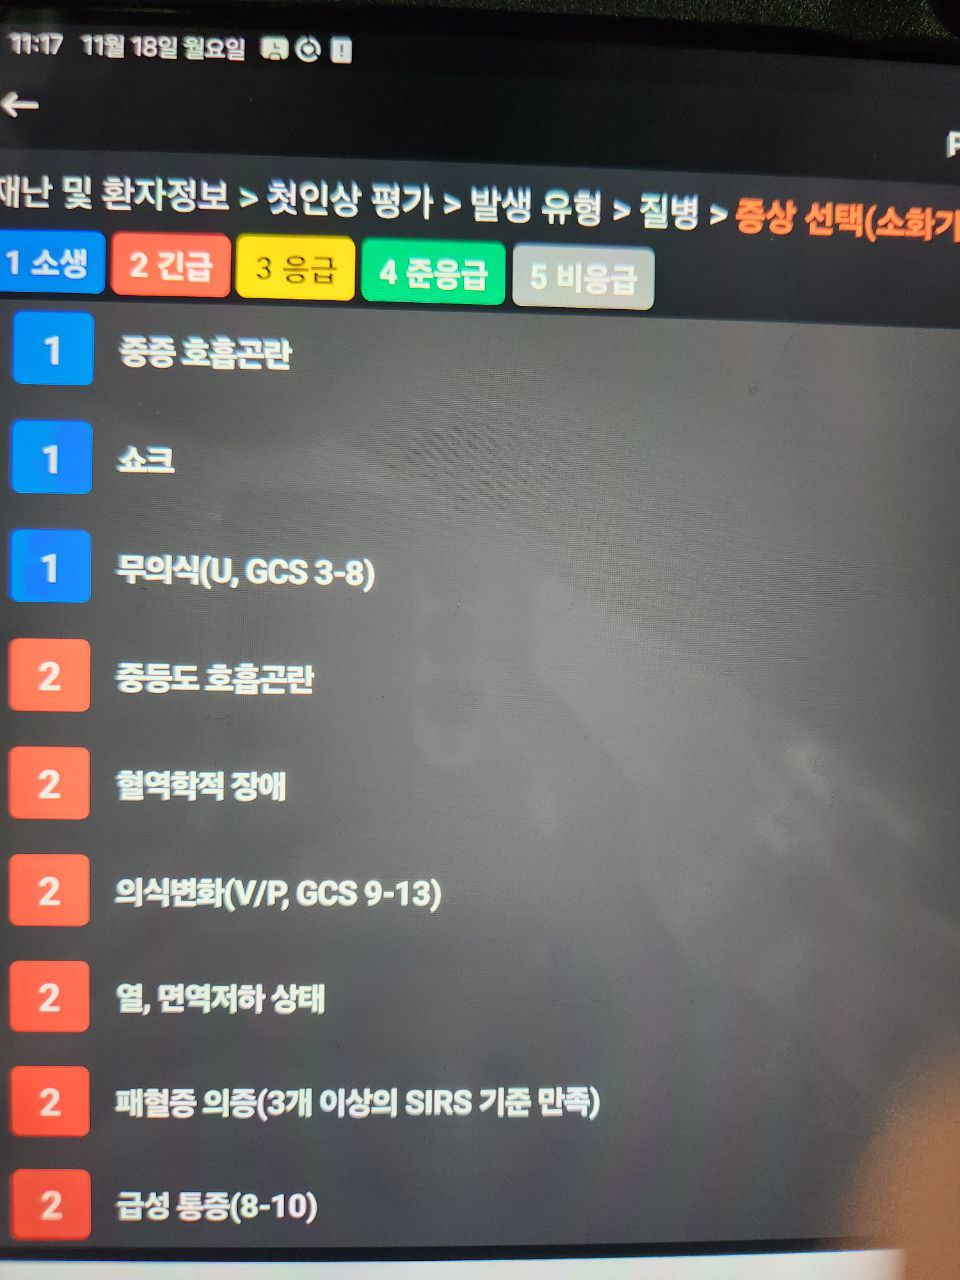

In [ ]:
df

,Filename,Transcript,Summary
0,audio3.mp3,동생이 콩 가지고 놀다가 코에 들어가서 한쪽 코가 막혔어요. 아무리 빼보려 해도 안...,동생이 코에 콩이 들어가서 한쪽 코가 막혀있는 상황. 콩을 빼내지 못하고 동생이 힘...
1,audio4.mp3,"아까 가다가 머리를 박았는데, 처음에는 괜찮다가, 지금 3시간 정도 지났는데, 머리...","머리를 박아서 3시간이 지나도 어지러움과 메스꺼움이 남아있는 상황인데, 응급 처치를..."
2,audio1.mp3,지금 아빠가 넘어졌어요. 머리에서 피가 나는데 숨은 쉬고 있어요. 지금 막 일어났어...,40대 여성이 계단에서 넘어져 머리에서 피가 나며 어지러움을 느끼고 있습니다. 응급...
3,audio5.mp3,화장실에서 미끄러워서 엉덩방아를 찍었어요. 그러고 꼬리뼈가 계속 아파요. 점점 아픈...,화장실에서 미끄러져 엉덩이를 다쳐 꼬리뼈가 계속 아프다고 합니다. 점점 아픔이 심해...
4,audio2.mp3,119죠. 제가 지금 열이 열이 올랐어요. 몇 도냐면은 38도 정도 돼요. 머리가 ...,"119에 전화하여 발열 증상과 두통, 혼돈 등을 보이는 상황에서 상담을 받는다. 3..."


In [ ]:

# filename, x=위도, y=경도
def audio_summary(filename, x, y):

#OpenAI API Key 환경 변수 설정
  def load_file(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

  # API 키 로드 및 환경변수 설정
  path = '/content/drive/MyDrive/project6_2/'
  openai.api_key = load_file(path + 'api_key.txt')
  os.environ['OPENAI_API_KEY'] = openai.api_key

  # 제공된 데이터 변환
  audio_path = '/content/drive/MyDrive/project6_2/audio/'

    # 음성파일 변환 함수
  def audio_to_text(audio_path, filename):
        file_path = os.path.join(audio_path, filename)
        try:
            with open(file_path, "rb") as audio_file:
                transcript = client.audio.transcriptions.create(
                    file=audio_file,
                    model="whisper-1",
                    language="ko",
                    response_format="text",
                )
            return transcript
        except Exception as e:
            return f"Error occurred: {str(e)}"

    # 오디오 변환
  print(f"Processing file: {filename}")
  transcript = audio_to_text(audio_path, filename)

  def text_summary(input_text):
      # OpenAI 클라이언트 생성
      client = OpenAI()

      # 시스템 역할과 응답 형식 지정
      system_role = '''당신은 119 전화 내용을 요약하는 어시스턴트입니다.
      응답은 다음의 형식을 지켜주세요
      {"summary": \"텍스트 요약\"}
      '''



      # 입력데이터를 GPT-3.5-turbo에 전달하고 답변 받아오기
      response = client.chat.completions.create(
          model="gpt-3.5-turbo",
          messages=[
              {
                  "role": "system",
                  "content": system_role
              },
              {
                  "role": "user",
                  "content": input_text
              }
          ]
      )

      # 응답 받기
      answer = response.choices[0].message.content

      # 응답형식을 정리하고 return
      summary = eval(answer)["summary"]
      return summary

    # 텍스트 요약
  summary = text_summary(transcript)

    # 결과 데이터프레임 생성
  result = {
        "Filename": filename,
        "Summary": summary,
        "위도": x,
        "경도": y
    }

  return result

In [ ]:
audio_summary("audio1.mp3", x= 37.5292881, y =  126.9063404)

Processing file: audio1.mp3


{'Filename': 'audio1.mp3',
 'Summary': '마흔아홉 살 네이너가 계단에서 넘어져 머리에서 피가 나면서 어지러워하는 상황. 숨은 쉬고 있으며 응급실 방문 여부에 대해 고민 중. 응급상황으로 판단되므로 즉시 응급실로 이동하는 것이 바람직함.',
 '위도': 37.5292881,
 '경도': 126.9063404}

In [ ]:
  audio_path = '/content/drive/MyDrive/project6_2/audio/'

In [ ]:
client = OpenAI()

def audio_to_text(filename):
    """
    주어진 음성 파일을 텍스트로 변환.

    """

    try:
        file_path = f"{audio_path}/{filename}"
        with open(file_path, "rb") as audio_file:
            transcript = client.audio.transcriptions.create(
                file=audio_file,
                model="whisper-1",
                language="ko",
                response_format="text",
            )
        return transcript
    except Exception as e:
        return f"Error occurred: {str(e)}"

def text_summary(input_text):
    """
    주어진 텍스트를 요약.
    """
    system_role = '''당신은 119 전화 내용을 요약하는 어시스턴트입니다.
    응답은 다음의 형식을 지켜주세요:
    {"summary": "텍스트 요약"}
    '''
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": system_role},
                {"role": "user", "content": input_text}
            ]
        )
        answer = response.choices[0].message.content
        summary = eval(answer)["summary"]
        return summary
    except Exception as e:
        return f"Error occurred: {str(e)}"

def pipeline(location_file, output_csv):
    """
    음성 파일 변환 및 요약 작업 파이프라인.
    - location_file: 위치 정보를 포함한 파일 경로 (데이터 입력)
    - output_csv: 결과를 저장할 CSV 파일 경로 (데이터 출력)
    """
    # Step 1: 위치 정보 데이터 로드
    location_data = pd.read_excel(location_file)
    location_data = location_data[["filename", "위도", "경도"]].rename(columns={"filename": "Filename"})

    location_data = location_data.dropna(subset=["Filename"])  # 빈 값 제거
    location_data = location_data[location_data["Filename"].apply(
        lambda x: os.path.isfile(f"{audio_path}/{x}")
    )]

    # Step 2: 음성 파일 변환 (STT)
    data_list = []
    for index, row in location_data.iterrows():
        filename = row["Filename"]
        print(f"Processing file: {filename}")
        transcript = audio_to_text(filename)
        data_list.append({"Filename": filename, "Transcript": transcript, "위도": row["위도"], "경도": row["경도"]})

    # Step 3: 텍스트 요약
    df = pd.DataFrame(data_list)
    df["Summary"] = ""
    for index, row in df.iterrows():
        print(f"Summarizing file: {row['Filename']}")
        summary = text_summary(row["Transcript"])
        df.at[index, "Summary"] = summary
        print(f"Summary for {row['Filename']}: {summary}")

    # Step 4: 'Transcript' 열 제거
    final_df = df.drop(columns=["Transcript"])

    # Step 5: 결과 저장
    final_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"Results saved to {output_csv}.")

    return final_df

In [ ]:
location_file = "/content/drive/MyDrive/project6_2/audio_location.xlsx"
output_csv = "/content/drive/MyDrive/project6_2/audio_summary_results_with_location.csv"

# 파이프라인 실행
final_df = pipeline(location_file, output_csv)

# 결과 확인
final_df.head()

Processing file: audio1.mp3
Processing file: audio2.mp3
Processing file: audio3.mp3
Processing file: audio4.mp3
Processing file: audio5.mp3
Summarizing file: audio1.mp3
Summary for audio1.mp3: 남성이 계단에서 넘어져 머리에서 피가 나며 조금 어지러워하고 있음. 상황을 보면 응급실로 이동하는 것이 좋음. 피가 많이 나고 있는데 마흔아홉 살인 노인에게도 높은 위험이 있을 수 있음.
Summarizing file: audio2.mp3
Summary for audio2.mp3: 고열 증세로 38도의 열이 있고 머리가 아프고 띵한 상태인 상황. 의심 증상이 있으니 즉시 응급실을 방문하거나 119에 상담해야 할 것으로 보임.
Summarizing file: audio3.mp3
Summary for audio3.mp3: 동생이 콩을 코에 넣어 막히면 미끄럼 영상을 이용하여 코를 불만기 위해 남이서로의 코에 강하게 부는 것을 시도해 보십시오. 만약 이 방법이 효과적이지 않다면 응급실을 찾아가 보급을 받도록 하십시오.
Summarizing file: audio4.mp3
Summary for audio4.mp3: 머리를 박고 3시간이 지났지만 어지러움과 메스꺼움이 있는 경우. 의료진의 도움을 받거나 의료기관을 찾아 방문하는 것이 좋습니다.
Summarizing file: audio5.mp3
Summary for audio5.mp3: 화장실에서 미끄러져 엉덩이를 다쳐 꼬리뼈가 계속 아픔. 점점 아픈데 응급실 방문 검토 필요
Results saved to /content/drive/MyDrive/project6_2/audio_summary_results_with_location.csv.


,Filename,위도,경도,Summary
0,audio1.mp3,37.358618,127.115036,남성이 계단에서 넘어져 머리에서 피가 나며 조금 어지러워하고 있음. 상황을 보면 응...
1,audio2.mp3,36.815571,127.128844,고열 증세로 38도의 열이 있고 머리가 아프고 띵한 상태인 상황. 의심 증상이 있으...
2,audio3.mp3,37.538435,126.989828,동생이 콩을 코에 넣어 막히면 미끄럼 영상을 이용하여 코를 불만기 위해 남이서로의 ...
3,audio4.mp3,35.185745,129.076541,머리를 박고 3시간이 지났지만 어지러움과 메스꺼움이 있는 경우. 의료진의 도움을 받...
4,audio5.mp3,36.503544,127.252941,화장실에서 미끄러져 엉덩이를 다쳐 꼬리뼈가 계속 아픔. 점점 아픈데 응급실 방문 검...


### (2) 전국 병원 응급실 정보 수집



#### 1) 인증키 발급

* 인증키 발급 절차
    * 1) data.go.kr 회원가입
    * 2) 국립중앙의료원_전국 응급의료기관 정보 조회 서비스
https://www.data.go.kr/data/15000563/openapi.do 로 이동
    * 3) 활용신청
        * 활용목적 : 기타(개인 학습 용도)
        * 상세 기능선택
            * 응급의료기관 목록정보 조회
            * 응급의료기관 위치정보 조회
            * 응급의료기관 기본정보 조회
    * 4) 인증키 확인
        * 마이페이지 > Open API > 활용신청현황
        * [승인] 국립중앙의료원_전국 응급의료기관 정보 조회 서비스
        * 일반 인증키(Decoding) 이용

#### 2) 데이터 수집

In [ ]:
# path 확인
path

In [ ]:
# 응급실 데이터 수집하기

url = "http://apis.data.go.kr/B552657/ErmctInfoInqireService/getEgytListInfoInqire"
# url = "http://apis.data.go.kr/B552657/ErmctInfoInqireService/getEgytLcinfoInqire"
serviceKey =  'gSPGGmZrtQ/Jp/MjkeNBhN276Q9XfSwAwCfqpwg/rlQnv5ki+IaGackTubKj6D+yZNlpet+KRcahgGHnXDt4TA=='     # 여러분의 일반 인증키(Decoding)

params = {
    'serviceKey': serviceKey,
    'pageNo': '1', 'numOfRows': '1000',  # 전체 응급실 수가 500여개 됨. 1000개면 충분
    'format': 'xml'
}

response = requests.get(url, params = params)

# 정상 수행 되었다면 200
print(response)

<Response [200]>


In [ ]:
print(response.content)

b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header><body><items><item><dutyAddr>\xec\x9a\xb8\xec\x82\xb0\xea\xb4\x91\xec\x97\xad\xec\x8b\x9c \xeb\x82\xa8\xea\xb5\xac \xeb\x82\xa8\xec\x82\xb0\xeb\xa1\x9c354\xeb\xb2\x88\xea\xb8\xb8 26 (\xec\x8b\xa0\xec\xa0\x95\xeb\x8f\x99)</dutyAddr><dutyEmcls>G009</dutyEmcls><dutyEmclsName>\xec\x9d\x91\xea\xb8\x89\xec\x8b\xa4\xec\x9a\xb4\xec\x98\x81\xec\x8b\xa0\xea\xb3\xa0\xea\xb8\xb0\xea\xb4\x80</dutyEmclsName><dutyName>(\xec\x9d\x98)\xeb\x82\xb4\xea\xb2\xbd\xec\x9d\x98\xeb\xa3\x8c\xec\x9e\xac\xeb\x8b\xa8\xec\x9a\xb8\xec\x82\xb0\xec\xa0\x9c\xec\x9d\xbc\xeb\xb3\x91\xec\x9b\x90</dutyName><dutyTel1>052-220-3300</dutyTel1><dutyTel3>052-220-3334</dutyTel3><hpid>A1700023</hpid><phpid>A1700023</phpid><rnum>1</rnum><wgs84Lat>35.54823820112527</wgs84Lat><wgs84Lon>129.30701143429678</wgs84Lon></item><item><dutyAddr>\xeb\xb6\x80\xec\x82\xb0\xea\xb4\x91\xec\x97\xad\xe

In [ ]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time

# API URL
list_info_url = "http://apis.data.go.kr/B552657/ErmctInfoInqireService/getEgytListInfoInqire"
detail_info_url = "http://apis.data.go.kr/B552657/ErmctInfoInqireService/getEgytBassInfoInqire"

# 인증키
serviceKey = 'gSPGGmZrtQ/Jp/MjkeNBhN276Q9XfSwAwCfqpwg/rlQnv5ki+IaGackTubKj6D+yZNlpet+KRcahgGHnXDt4TA=='

# 병원 목록 조회
params_list = {
    'serviceKey': serviceKey,
    'pageNo': '1',
    'numOfRows': '1000',
    'format': 'xml'
}

response_list = requests.get(list_info_url, params=params_list)

# 병원 목록 데이터 파싱
root_list = ET.fromstring(response_list.text)

# 최종 데이터를 저장할 리스트
final_data = []

# 시작 시간 기록
start_time = time.time()

for idx, item in enumerate(root_list.findall('.//item'), start=1):
    # 병원 기본 정보 수집
    hpid = item.findtext('hpid')  # 병원 고유 ID
    duty_name = item.findtext('dutyName')  # 병원 이름
    duty_addr = item.findtext('dutyAddr')  # 병원 주소
    duty_tel = item.findtext('dutyTel1')  # 대표 전화
    duty_tel_3 = item.findtext('dutyTel3')  # 응급실 전화
    duty_emcls_name = item.findtext('dutyEmclsName')  # 응급의료기관 분류명
    wgs84_lon = item.findtext('wgs84Lon')  # 병원 경도
    wgs84_lat = item.findtext('wgs84Lat')  # 병원 위도

    # 진행 상황 출력
    print(f"Processing ({idx}/{len(root_list.findall('.//item'))}): 병원 이름 = {duty_name}, 병원 ID = {hpid}")

    # 병원 상세 정보 조회
    params_detail = {
        'serviceKey': serviceKey,
        'HPID': hpid,
        'format': 'xml'
    }
    try:
        response_detail = requests.get(detail_info_url, params=params_detail)
        response_detail.raise_for_status()  # 요청 성공 여부 확인

        # 상세 데이터 파싱
        root_detail = ET.fromstring(response_detail.text)

        # 병원 상세 정보 초기화
        duty_eryn = None  # 응급실 운영 여부
        duty_hano = None  # 병상 수
        duty_mapimg = None  # 병원 상세 주소

        for detail in root_detail.findall('.//item'):
            # 병원별 상세 정보를 정확히 저장
            duty_eryn = detail.findtext('dutyEryn')  # 응급실 운영 여부
            duty_hano = detail.findtext('dutyHano')  # 병상 수
            duty_mapimg = detail.findtext('dutyMapimg')  # 병원 상세 주소

        # 데이터를 리스트에 추가
        final_data.append({
            '병원이름': duty_name,
            '주소': duty_addr,
            '상세주소': duty_mapimg if duty_mapimg else "N/A",
            '대표전화': duty_tel,
            '응급실전화': duty_tel_3 if duty_tel_3 else "N/A",
            '응급실운영여부': duty_eryn if duty_eryn else "N/A",
            '병상수': duty_hano if duty_hano else "N/A",
            '응급의료기관분류명': duty_emcls_name,
            '경도': wgs84_lon,
            '위도': wgs84_lat
        })

    except requests.exceptions.RequestException as e:
        print(f"Error fetching details for 병원 이름 = {duty_name}, 병원 ID = {hpid}: {e}")

    # 예상 남은 시간 계산 및 출력
    elapsed_time = time.time() - start_time
    avg_time_per_request = elapsed_time / idx
    remaining_requests = len(root_list.findall('.//item')) - idx
    estimated_remaining_time = remaining_requests * avg_time_per_request
    print(f"소요 시간: {elapsed_time:.2f}s, 예상 남은 시간: {estimated_remaining_time:.2f}s\n")

# 데이터프레임으로 변환
df = pd.DataFrame(final_data)

# 데이터프레임 확인
print(df.head())

# CSV로 저장
df.to_csv("emergency_medical_info_corrected.csv", index=False, encoding="utf-8-sig")
print("데이터가 'emergency_medical_info_corrected.csv'로 저장되었습니다.")


Processing (1/526): 병원 이름 = (의)내경의료재단울산제일병원, 병원 ID = A1700023
소요 시간: 0.52s, 예상 남은 시간: 272.99s

Processing (2/526): 병원 이름 = (의)서일의료재단기장병원, 병원 ID = A1200028
소요 시간: 1.32s, 예상 남은 시간: 345.84s

Processing (3/526): 병원 이름 = (의)성세의료재단 뉴성민병원, 병원 ID = A1400008
소요 시간: 2.41s, 예상 남은 시간: 419.37s

Processing (4/526): 병원 이름 = (의)영문의료재단다보스병원, 병원 ID = A2100019
소요 시간: 2.94s, 예상 남은 시간: 383.21s

Processing (5/526): 병원 이름 = (의)효심의료재단용인서울병원, 병원 ID = A2100122
소요 시간: 3.43s, 예상 남은 시간: 357.62s

Processing (6/526): 병원 이름 = (재)미리내천주성삼성직수도회천주성삼병원, 병원 ID = A1300081
소요 시간: 3.97s, 예상 남은 시간: 344.48s

Processing (7/526): 병원 이름 = KS병원, 병원 ID = A1500019
소요 시간: 5.80s, 예상 남은 시간: 429.90s

Processing (8/526): 병원 이름 = 가톨릭관동대학교국제성모병원, 병원 ID = A1400015
소요 시간: 6.29s, 예상 남은 시간: 407.41s

Processing (9/526): 병원 이름 = 가톨릭대학교 인천성모병원, 병원 ID = A1400012
소요 시간: 7.06s, 예상 남은 시간: 405.60s

Processing (10/526): 병원 이름 = 가톨릭대학교부천성모병원, 병원 ID = A2100052
소요 시간: 8.25s, 예상 남은 시간: 425.61s

Processing (11/526): 병원 이름 = 가톨릭대학교성빈센트병원, 병원 ID = A2100012
소요 

In [ ]:
df.head()

,병원이름,주소,상세주소,대표전화,응급실전화,응급실운영여부,병상수,응급의료기관분류명,경도,위도
0,(의)내경의료재단울산제일병원,울산광역시 남구 남산로354번길 26 (신정동),N/A,052-220-3300,052-220-3334,1,148,응급실운영신고기관,129.30701143429678,35.54823820112527
1,(의)서일의료재단기장병원,부산광역시 기장군 기장읍 대청로72번길 6,버스정류장: 청강사거리,051-723-0171,051-723-2119,1,154,지역응급의료기관,129.21649161387128,35.23602946449906
2,(의)성세의료재단 뉴성민병원,"인천광역시 서구 칠천왕로33번길 17 (석남동, 신석로 70(석남1동, 성민병원))",서인천월드메르디앙@ 부근,032-726-1000,032-726-1190,1,299,지역응급의료기관,126.669478649026,37.5089936801167
3,(의)영문의료재단다보스병원,"경기도 용인시 처인구 백옥대로1082번길 18, 다보스종합병원 (김량장동)",N/A,031-8021-2114,031-8021-2130,1,251,지역응급의료센터,127.21049868474802,37.234641294534285
4,(의)효심의료재단용인서울병원,경기도 용인시 처인구 고림로 81 (고림동),N/A,031-337-0114,031-336-0119,1,200,지역응급의료기관,127.2144914405,37.240316373


In [ ]:
df.head(20)

,병원이름,주소,상세주소,대표전화,응급실전화,응급실운영여부,병상수,응급의료기관분류명,경도,위도
0,(의)내경의료재단울산제일병원,울산광역시 남구 남산로354번길 26 (신정동),N/A,052-220-3300,052-220-3334,1,148,응급실운영신고기관,129.30701143429678,35.54823820112527
1,(의)서일의료재단기장병원,부산광역시 기장군 기장읍 대청로72번길 6,버스정류장: 청강사거리,051-723-0171,051-723-2119,1,154,지역응급의료기관,129.21649161387128,35.23602946449906
2,(의)성세의료재단 뉴성민병원,"인천광역시 서구 칠천왕로33번길 17 (석남동, 신석로 70(석남1동, 성민병원))",서인천월드메르디앙@ 부근,032-726-1000,032-726-1190,1,299,지역응급의료기관,126.669478649026,37.5089936801167
3,(의)영문의료재단다보스병원,"경기도 용인시 처인구 백옥대로1082번길 18, 다보스종합병원 (김량장동)",N/A,031-8021-2114,031-8021-2130,1,251,지역응급의료센터,127.21049868474802,37.234641294534285
4,(의)효심의료재단용인서울병원,경기도 용인시 처인구 고림로 81 (고림동),N/A,031-337-0114,031-336-0119,1,200,지역응급의료기관,127.2144914405,37.240316373
5,(재)미리내천주성삼성직수도회천주성삼병원,"대구광역시 수성구 달구벌대로 3190 (신매동, 천주성삼병원)",수성구 신매동,053-790-1000,053-790-0555,1,289,지역응급의료기관,128.70573339664242,35.84022544517349
6,KS병원,광주광역시 광산구 왕버들로 220 (수완동),N/A,062-975-9000,062-975-9119,1,269,지역응급의료센터,126.83322475289853,35.197963178976366
7,가톨릭관동대학교국제성모병원,"인천광역시 서구 심곡로100번길 25 (심곡동, 인천국제성모병원)",인천 인재개발원 및 인천소방안전학교 인근,1600-8291,032-290-3065,1,632,지역응급의료센터,126.68360486878781,37.542372653918065
8,가톨릭대학교 인천성모병원,인천광역시 부평구 동수로 56 (부평동),동수역2번출구 하차 후 도보10분,032-280-6364,032-280-6107,1,789,지역응급의료센터,126.724708130675,37.4845586499062
9,가톨릭대학교부천성모병원,"경기도 부천시 원미구 소사로 327, 가톨릭대학교 부천성모병원 (소사동)",N/A,032-1577-0675,032-340-2100,1,647,지역응급의료센터,126.79243459154999,37.4874477394264


In [ ]:
# XML 데이터 파싱
import xml.etree.ElementTree as ET

root = ET.fromstring(response.text)

# 모든 태그 출력
for item in root.findall('.//item'):
    print("----")
    for child in item:
        print(f"{child.tag}: {child.text}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
dutyTel3: 051-550-9391
hpid: A1200018
phpid: A1200018
rnum: 109
wgs84Lat: 35.204273174435535
wgs84Lon: 129.08021549527504
----
dutyAddr: 서울특별시 영등포구 시흥대로 657 (대림동, 대림성모병원)
dutyEmcls: G007
dutyEmclsName: 지역응급의료기관
dutyName: 대림성모병원
dutyTel1: 02-829-9000
dutyTel3: 02-829-9129
hpid: A1100037
phpid: A1100037
rnum: 110
wgs84Lat: 37.49068925436284
wgs84Lon: 126.90716948025135
----
dutyAddr: 전라남도 무안군 무안읍 몽탄로 65
dutyEmcls: G007
dutyEmclsName: 지역응급의료기관
dutyName: 대송의료재단무안병원
dutyTel1: 061-450-3000
dutyTel3: 061-450-3119
hpid: A2600003
phpid: A2600003
rnum: 111
wgs84Lat: 34.99175918279295
wgs84Lon: 126.48926066040337
----
dutyAddr: 경기도 안산시 단원구 선부광장로 103 (선부동)
dutyEmcls: G006
dutyEmclsName: 지역응급의료센터
dutyName: 대아의료재단한도병원
dutyTel1: 031-8040-1114
dutyTel3: 031-8040-1129
hpid: A2100017
phpid: A2100017
rnum: 112
wgs84Lat: 37.334033447174896
wgs84Lon: 126.80765584591039
----
dutyAddr: 전북특별자치도 전주시 덕진구 견훤로 390 (우아동3가,(우아동3가))
dutyEmcls: G006
dutyEmclsName: 지역응급의료센터
dutyName

In [ ]:
# csv 파일로 저장(인덱스 제외)
# CSV로 저장
df.to_csv("emergency_medical_info_corrected.csv", index=False, encoding="utf-8-sig")
print("데이터가 'emergency_medical_info_corrected.csv'로 저장되었습니다.")

## **Mission Complete!**

수고 많았습니다!